# Model Selection and Implementation - Wheat Pricing Data
## Time Series and Machine Learning Final Project Code
## Will Bartlett and David Whitmer

In [253]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
import itertools
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler


In [185]:
#Import Dataset
df = pd.read_csv('../Final Data/Final_Data.csv')
#drop temperature data; low correlation to target
df = df.drop(columns = 'avg_temp')

## 1 Time Series Model Tests
### 1.1 AR Model

In [9]:
#Find optimal lag to test
best_model = ar_select_order(df['wheat_price'], maxlag=25, ic='aic', old_names=False)
print(f"Optimal lag order selected for Monthly return : {best_model.ar_lags}")

Optimal lag order selected for Monthly return : [1, 2, 3, 4, 5, 6, 7, 8]


In [11]:
#AR(1) Model
ar_1 = AutoReg(df['wheat_price'], lags = 1).fit()
ar_1_aic = ar_1.aic
print('AR(1) Results: \n',ar_1.summary())

AR(1) Results: 
                             AutoReg Model Results                             
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                     AutoReg(1)   Log Likelihood                -390.448
Method:               Conditional MLE   S.D. of innovations              0.613
Date:                Wed, 30 Apr 2025   AIC                            786.896
Time:                        22:34:31   BIC                            799.017
Sample:                             1   HQIC                           791.687
                                  421                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2741      0.083      3.308      0.001       0.112       0.436
wheat_price.L1     0.9438      0.016     58.648      0.000       0.912       0.975
                   

In [13]:
#AR(2) Model
ar_2 = AutoReg(df['wheat_price'], lags = 2).fit()
ar_2_aic = ar_2.aic
print('\nAR(2) Results: \n',ar_2.summary())


AR(2) Results: 
                             AutoReg Model Results                             
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                     AutoReg(2)   Log Likelihood                -374.137
Method:               Conditional MLE   S.D. of innovations              0.591
Date:                Wed, 30 Apr 2025   AIC                            756.273
Time:                        22:34:32   BIC                            772.425
Sample:                             2   HQIC                           762.658
                                  421                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2043      0.081      2.526      0.012       0.046       0.363
wheat_price.L1     0.6891      0.047     14.650      0.000       0.597       0.781
wheat_price.L2    

### 1.2 ARIMA Model

In [9]:
#Find best params for ARIMA model
p = range(0, 3)  # AR order
d = range(0, 2)  # Differencing
q = range(0, 3)  # MA order
pdq = list(itertools.product(p, d, q))

#use aic for best model, set up saves
best_aic = float('inf')
best_pdq = None

for param in pdq:
    try:
        model = ARIMA(df['wheat_price'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

best_arima_aic = best_aic

print(f"Best ARIMA order based on AIC: {best_pdq}")

Best ARIMA order based on AIC: (0, 1, 1)


In [10]:
#Test best model ARIMA(0,1,1)
arima_011 = ARIMA(df['wheat_price'], order=best_pdq).fit()
print('ARIMA(0,1,1) Results: \n',arima_011.summary())

ARIMA(0,1,1) Results: 
                                SARIMAX Results                                
Dep. Variable:            wheat_price   No. Observations:                  421
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -374.330
Date:                Wed, 30 Apr 2025   AIC                            752.660
Time:                        22:16:41   BIC                            760.741
Sample:                             0   HQIC                           755.854
                                - 421                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3533      0.027    -13.308      0.000      -0.405      -0.301
sigma2         0.3480      0.008     44.367      0.000       0.333       0.363
Ljung-Box (L1) (Q):         

### 1.3 ARIMAX Model

In [179]:
#Save exogenous data separately
exog_data = df.copy().drop(columns = ['wheat_price','date'])

#standardize exogenous features
exog_data = (exog_data - exog_data.mean()) / exog_data.std()

In [13]:
#Find best params for ARIMAX model
p = range(0, 3)  #AR order
d = range(0, 2)  #differencing options
q = range(0, 3)  #MA order
pdq = list(itertools.product(p, d, q))

#find best model params by aic
best_arimax_aic = float('inf')
best_arimax_params = None
for param in pdq:
    try:
        model = SARIMAX(df['wheat_price'], 
                        exog=exog_data,
                        order=param, 
                        seasonal_order=(0, 0, 0, 0))  #don't add seasonality
        results = model.fit(disp=False)
        if results.aic < best_arimax_aic:
            best_arimax_aic = results.aic
            best_arimax_params = param
    except:
        continue

print(f"Best ARIMAX model order based on AIC: {best_arimax_params}; AIC = {best_arimax_aic}")

Best ARIMAX model order based on AIC: (2, 1, 1); AIC = 727.964382296861


In [14]:
#Test ARIMAX(2,1,1)
arimax_211 = SARIMAX(df['wheat_price'], 
                     exog=exog_data,
                     order=best_arimax_params, 
                     seasonal_order=(0, 0, 0, 0)).fit(disp=False)
print('ARIMAX(2,1,1) Results: \n',arimax_211.summary())

ARIMAX(2,1,1) Results: 
                                SARIMAX Results                                
Dep. Variable:            wheat_price   No. Observations:                  421
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -351.982
Date:                Wed, 30 Apr 2025   AIC                            727.964
Time:                        22:16:48   BIC                            776.447
Sample:                             0   HQIC                           747.127
                                - 421                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fertilizer_idx        0.5031      0.247      2.035      0.042       0.019       0.988
drought_idx          -0.1061      0.082     -1.289      0.198      -0.268       0.055

### 1.4 SARIMAX Model

#### 1.4.1 ACF Plot For Seasonality Test

<Figure size 1200x1000 with 0 Axes>

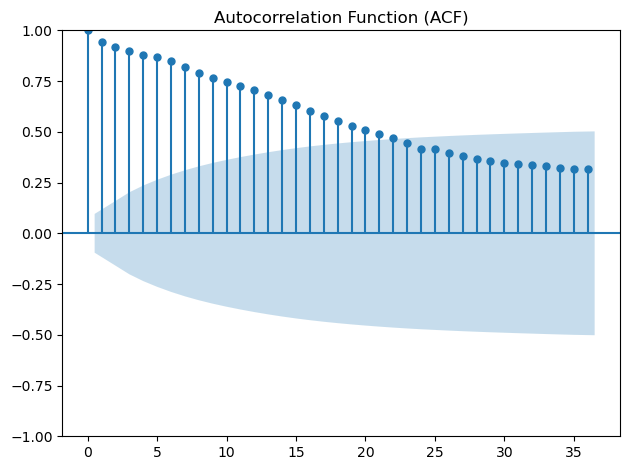

In [17]:
#Plot ACF
plt.figure(figsize=(12, 10))
plot_acf(df['wheat_price'], lags=36 ) 
plt.title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.savefig('../Visualizations/ACF.png')
plt.show()

#### 1.4.2 SARIMAX Model Implementation

In [19]:
#Find best params for SARIMAX
# Define parameter ranges for both ARIMA and seasonal components
p = range(0, 3)  #AR order
d = range(0, 2)  #Differencing
q = range(0, 3)  #MA order
P = range(0, 2)  #seasonal AR order
D = range(0, 2)  #seasonal differencing
Q = range(0, 2)  #seasonal MA order
s = 12  #yearly seasonality assumed

#Create all combinations of seasonal parameters
arima_pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

# Find best SARIMAX model with both ARIMA and seasonal components
best_sarimax_aic = float('inf')
best_params = None
best_seasonal_params = None

# Grid search over seasonal parameters
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(df['wheat_price'], 
                           exog=exog_data,
                           order=param, #use best arimax params
                           seasonal_order=seasonal_param)
            
            results = model.fit(disp=False, maxiter=100)
            current_aic = results.aic
            
            if current_aic < best_sarimax_aic:
                best_sarimax_aic = current_aic
                best_params = param
                best_seasonal_params = seasonal_param
                sarimax_results = results
        except Exception as e:
            continue

print(f"\nBest SARIMAX model: SARIMAX{best_params}x{best_seasonal_params}")

KeyboardInterrupt: 

In [ ]:
#Test SARIMAX(1,1,2)x(0,0,1,12)
print(sarimax_results.summary())

In [181]:
smax = SARIMAX(df['wheat_price'], exog=exog_data,order=(1,1,2),seasonal_order=(0,0,1,12))
smax_res = smax.fit(disp=False, maxiter=100)
print(smax_res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          wheat_price   No. Observations:                  421
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 12)   Log Likelihood                -350.191
Date:                              Thu, 01 May 2025   AIC                            726.382
Time:                                      09:01:20   BIC                            778.905
Sample:                                           0   HQIC                           747.142
                                              - 421                                         
Covariance Type:                                opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fertilizer_idx        0.4355      0.292      1.492      0.136      -0.137       1.00

### 1.5 AutoRegressive Model Comparisons

In [ ]:
#Compare AIC values
ts_aic = pd.DataFrame({
    'Model': ['AR(1)','AR(2)','ARIMA',"ARIMAX",'SARIMAX'],
    'AIC': [ar_1_aic, ar_2_aic, best_arima_aic, best_arimax_aic, best_sarimax_aic]
})
ts_aic

### 1.6 Best AR Model vs Actual Price

In [188]:
#sarimax plot prep
sarimax_pred = sarimax_results.get_prediction().predicted_mean
sarimax_plot = df.copy()
sarimax_plot['sarimax_predictions'] = sarimax_pred.drop(0)
#ensure datetime type
df['date'] = pd.to_datetime(df['date'])

NameError: name 'sarimax_results' is not defined

In [ ]:
#Plot SARIMAX Predictions and Forecasts
plt.figure(figsize=(12, 6))

#plot true time series
plt.plot(df['date'],df['wheat_price'] , 'b-', 
         linewidth=1, label='Actual Wheat Prices')

#plot predictions
plt.plot(df['date'], sarimax_plot['sarimax_predictions'], 'r--', 
         linewidth=1, label='Predicted Wheat Prices')

#label and save
plt.title('SARIMAX Model Fit', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Wheat Price ($/Bushel)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Visualizations/Full_SARIMAX_Prediction.png')
plt.show()

### 1.7 Volatility Models

In [15]:
#calculate price change for all priced variables
df_change=df.copy()
df_change['wheat_price_change'] = df_change['wheat_price'].diff()
df_change['crude_oil_change'] = df_change['crude_oil_price'].diff()
df_change['flour_change'] = df_change['flour_price'].diff()
df_change['corn_change'] = df_change['corn_price'].diff()
df_change['cpi_change'] = df_change['cpi'].diff()
df_change = df_change.dropna()
df_change = df_change.drop(columns = ['wheat_price','flour_price','crude_oil_price','corn_price','cpi'])

#### 1.7.1 ARCH Model

In [18]:
#fit arch(1) model
arch_model = arch_model(df_change['wheat_price_change'], vol='ARCH', p=1, mean='AR', lags=1)
arch_result = arch_model.fit(update_freq=0, disp='off')
print(arch_result.summary())

                           AR - ARCH Model Results                            
Dep. Variable:     wheat_price_change   R-squared:                       0.078
Mean Model:                        AR   Adj. R-squared:                  0.075
Vol Model:                       ARCH   Log-Likelihood:               -279.118
Distribution:                  Normal   AIC:                           566.235
Method:            Maximum Likelihood   BIC:                           582.387
                                        No. Observations:                  419
Date:                Wed, Apr 30 2025   Df Residuals:                      417
Time:                        22:34:45   Df Model:                            2
                                  Mean Model                                 
                    coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------------------
Const            -0.0401  3.262e-02     -1.228      0.2

#### 1.7.2 GARCH Model

In [21]:
#test garch(1,1) model for volatility
df_garch_model = arch_model(df_change['wheat_price_change'], vol='GARCH', p=1,q=1, mean='AR', lags=1)
garch_result = df_garch_model.fit(update_freq=0, disp='off')
print(garch_result.summary())

TypeError: 'ARX' object is not callable

## 2 Machine Learning Models

### 2.1 Data Preprocessing

In [190]:
#add lagged values for all values for decision tree
df['date']=pd.to_datetime(df['date'])
columns = df.columns.tolist()
lag_periods = np.arange(1,7) #add 6 month lagged variables

#Create lags for each column in the dataframe
for col in columns:
    if df[col].dtype not in ['float64', 'int64']:
        continue
        
    #create lagged vars for col
    for lag in lag_periods:
        lag_name = f'{col}_lag_{lag}'
        df[lag_name] = df[col].shift(lag)

df = df.dropna()
# Extract year and month as numeric features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
#drop date column
df = df.drop(columns = 'date')

In [37]:
#same for change df
columns = df_change.columns.tolist()
lag_periods = np.arange(1,7) #add 6 month lagged variables

#Create lags for each column in the dataframe
for col in columns:
    if df_change[col].dtype not in ['float64', 'int64']:
        continue
        
    #create lagged vars for col
    for lag in lag_periods:
        lag_name = f'{col}_lag_{lag}'
        df[lag_name] = df_change[col].shift(lag)

df_change = df_change.dropna()

# Extract year and month as numeric features
df_change['year'] = df_change.index.year  # 2020, 2021, 2022, etc.
df_change['month'] = df_change.index.month  # 1-12
#drop date column
df_change = df_change.drop(columns = 'date')

AttributeError: 'Index' object has no attribute 'year'

In [192]:
#split data into 80% train and 20% test sets
y = df['wheat_price'] # use wheat price as target 
X = df.drop(columns = 'wheat_price')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.2 Basic Decision Tree Regressor

In [195]:
#hyperparameter tuning for best decision tree model
params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#run grid search cross-validation for tuning
dt_model = DecisionTreeRegressor(random_state=42) #initialize
dt_gridsearch = GridSearchCV(dt_model, params,cv=5) #start gridsearch
dt_gridsearch.fit(X_train, y_train) #fit model
best_params = dt_gridsearch.best_params_ #find best parameters
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [197]:
#run model using best hyperparameters
best_dt = DecisionTreeRegressor(**best_params,random_state=42) #initialize
best_dt.fit(X_train, y_train) #fit model
dt_pred = best_dt.predict(X_test) #predict

In [199]:
#calculate performance measures
dt_mse = mean_squared_error(y_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)

### 2.3 Ensemble Learning Models

#### 2.3.1 Random Forest Regressor Model

In [201]:
#hyperparameter tune for best rf model
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
#run grid search cross-validation for tuning
rf_model = RandomForestRegressor(random_state=42) #initialize
rf_gridsearch = GridSearchCV(rf_model, rf_params,cv=5) #start gridsearch
rf_gridsearch.fit(X_train, y_train) #fit model
best_rf_params = rf_gridsearch.best_params_ #find best parameters
print(f"Best Random Forest Parameters: {best_rf_params}")

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [202]:
#run random forest model
best_rf = RandomForestRegressor(**best_params, random_state=42) #initialize
best_rf.fit(X_train, y_train) #fit
rf_pred = best_rf.predict(X_test) #predict

In [203]:
#calculate performance measures
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

#### 2.3.2 Histogram Gradient Boosting Regressor Model

In [205]:
#hyperparameter tuning for best hist xgboosting model to handle null value
gb_params = {
    'max_iter': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
gb_model = HistGradientBoostingRegressor(random_state=42) #initialize
gb_gridsearch = GridSearchCV(gb_model, gb_params,cv=5)
gb_gridsearch.fit(X_train, y_train) #fit model
best_gb_params = gb_gridsearch.best_params_ #find best parameters
print(f"Best Random Forest Parameters: {best_gb_params}")

Best Random Forest Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 200}


In [206]:
#run model using best hyperparameters
best_gb = HistGradientBoostingRegressor(**best_gb_params,random_state=42) #initialize
best_gb.fit(X_train, y_train) #fit
gb_pred = best_gb.predict(X_test)

In [207]:
#calculate performance measures
gb_mse = mean_squared_error(y_test, gb_pred)
gb_rmse = np.sqrt(rf_mse)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

### 2.4 Model Evaluation

#### 2.4.1 Model Comparisons

In [213]:
dt_comparison = {
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'MSE': [dt_mse, rf_mse, gb_mse],
    'RMSE': [dt_rmse, rf_rmse, gb_rmse],
    'R²': [dt_r2, rf_r2, gb_r2]
}
dt_comparison = pd.DataFrame(dt_comparison)
dt_comparison

,Model,MSE,RMSE,R²
0,Decision Tree,0.494895,0.703488,0.833778
1,Random Forest,0.251755,0.501751,0.915442
2,Gradient Boosting,0.198760,0.501751,0.933242


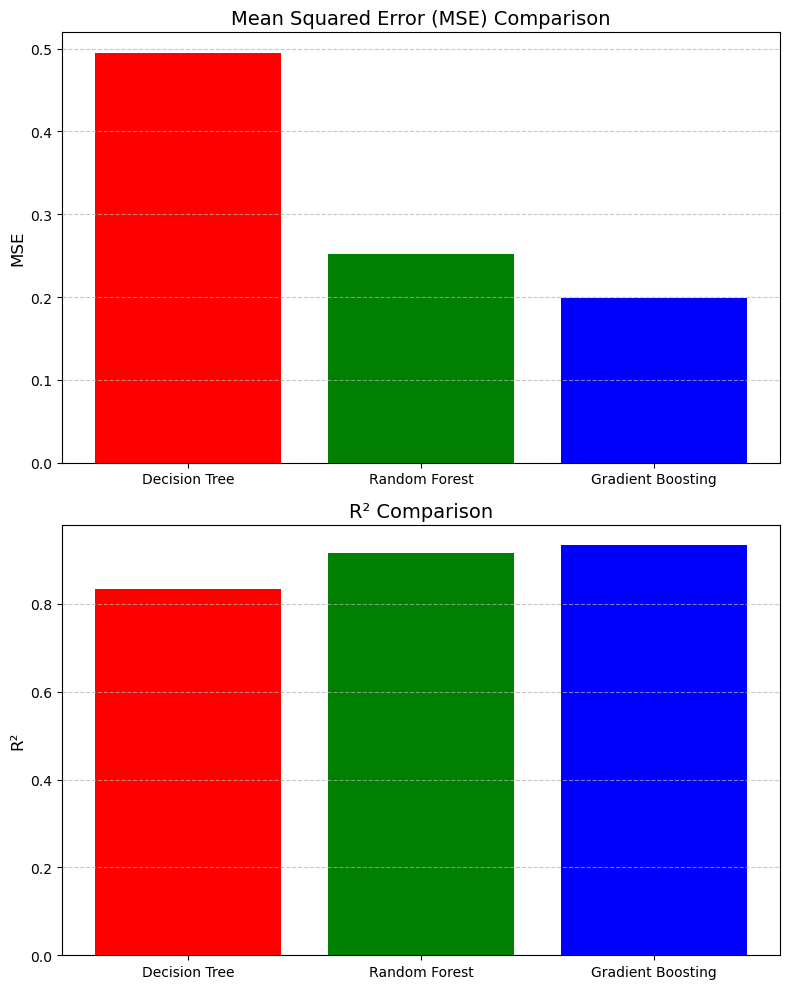

In [222]:
#plot MSE and R squared comparisons
plt.figure(figsize=(8, 10))

#subplot 1 for MSE comparisons
plt.subplot(2, 1, 1)
bars1 = plt.bar(dt_comparison['Model'], dt_comparison['MSE'], color=['r','g','b'], linewidth=1)
plt.title('Mean Squared Error (MSE) Comparison', fontsize=14)
plt.ylabel('MSE', fontsize=12)
#plt.ylim(0.6,1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#subplot 2 for r squared comparisons
plt.subplot(2, 1, 2)
bars2 = plt.bar(dt_comparison['Model'], dt_comparison['R²'], color=['r','g','b'], linewidth=1)
plt.title('R² Comparison', fontsize=14)
plt.ylabel('R²', fontsize=12)
#plt.ylim(0, 0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#save and show
plt.tight_layout()
plt.savefig('../Visualizations/Model_Comparison.png')
plt.show()

#### 2.4.2 Feature Importance

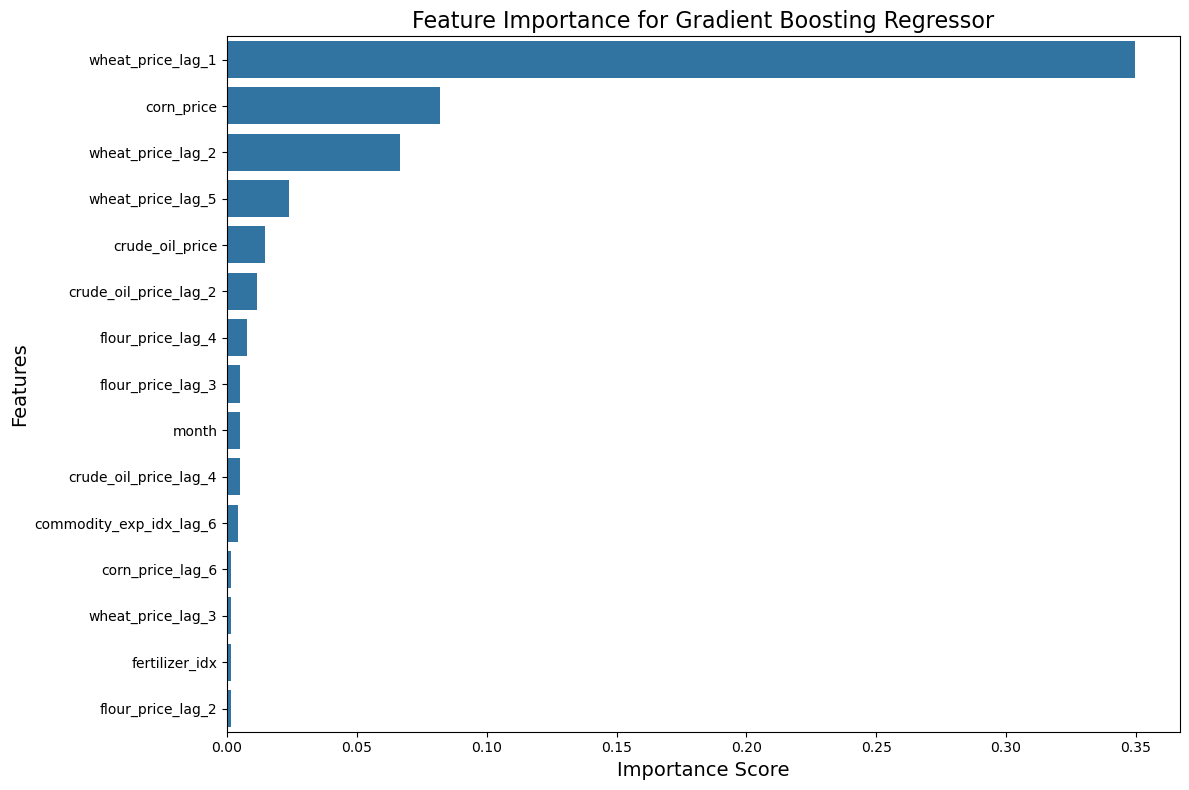

In [225]:
#plot feature importance
result = permutation_importance(
    best_gb,
    X_test, y_test,
    n_repeats=10,
    random_state=42
)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

top_features = feature_importance.head(15)

#plot above
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Feature Importance for Gradient Boosting Regressor', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.savefig('../Visualizations/GB_Feature_Importance.png')
plt.show()

#### 2.4.3 XGBoost Predictions vs Actual Prices

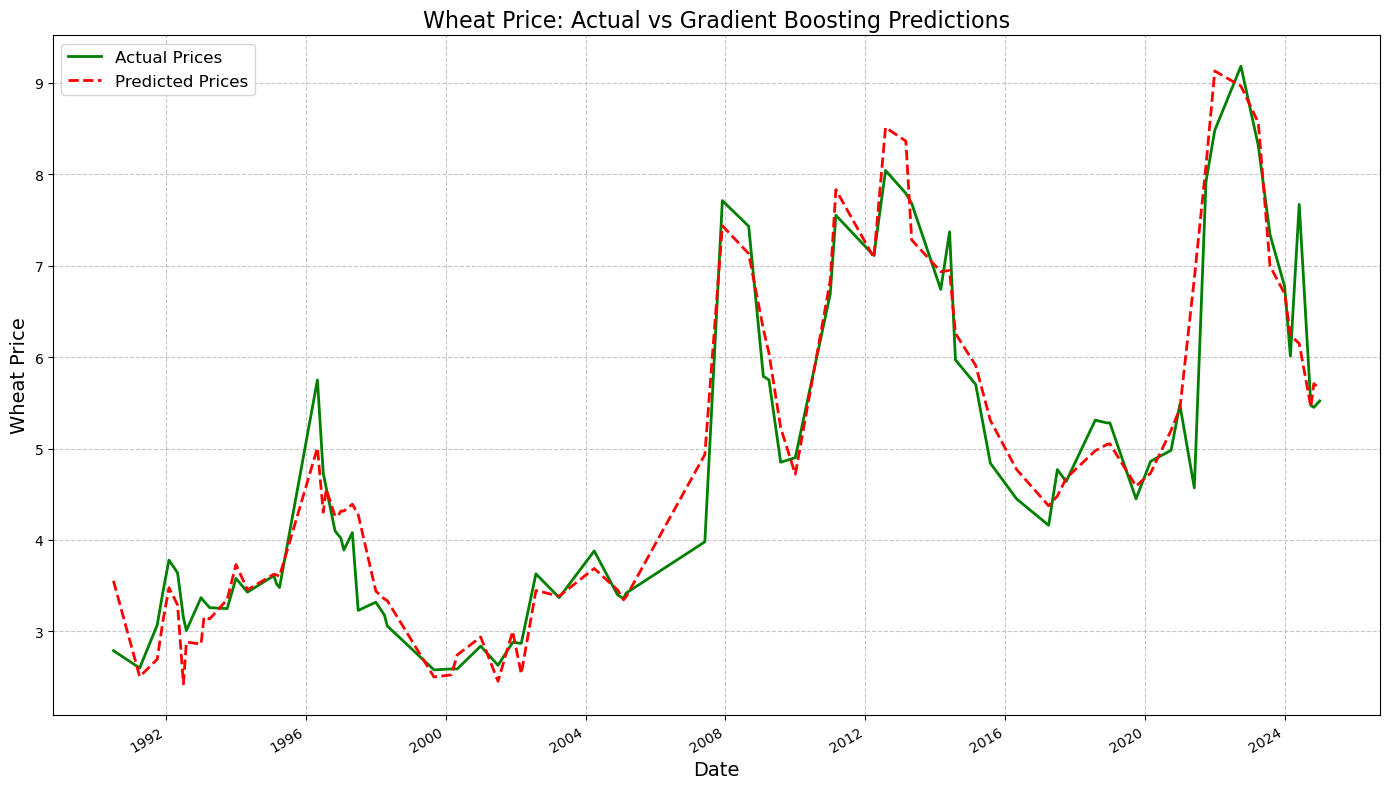

In [239]:
#plot xgboost vs actual values
dates = [datetime(year=int(X_test.iloc[i]['year']), month=int(X_test.iloc[i]['month']), day=1) 
         for i in range(len(X_test))]

# Create a DataFrame with dates, actual values, and predictions
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual': y_test.values,
    'Gradient Boosting': gb_pred
})

comparison_df = comparison_df.sort_values('Date')

plt.figure(figsize=(14, 8))

# Plot actual and predicted values
plt.plot(comparison_df['Date'], comparison_df['Actual'], 'g-', linewidth=2, markersize=8, label='Actual Prices')
plt.plot(comparison_df['Date'], comparison_df['Gradient Boosting'], 'r--', linewidth=2, markersize=8, label='Predicted Prices')

plt.title('Wheat Price: Actual vs Gradient Boosting Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Wheat Price', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format the x-axis to show dates nicely
plt.gcf().autofmt_xdate()  # Auto-format date labels
plt.tight_layout()
plt.savefig('../Visualizations/xbgoost_predictions.png')
plt.show()

## 3 Recurrent Neural Network